# 用随机森林回归填补缺失值

In [1]:
# 1. 导入需要的库
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [2]:
# 2. 导入数据并进行探索
data = load_boston()

In [3]:
data

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 3

In [4]:
df_data=pd.DataFrame(data.data)

In [5]:
df_target=pd.DataFrame(data.target)

In [39]:
type(df_target)

pandas.core.frame.DataFrame

In [6]:
df = pd.concat([df_data,df_target],axis=1)

In [7]:
# 一共有506*13个数据
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       506 non-null    float64
 1   1       506 non-null    float64
 2   2       506 non-null    float64
 3   3       506 non-null    float64
 4   4       506 non-null    float64
 5   5       506 non-null    float64
 6   6       506 non-null    float64
 7   7       506 non-null    float64
 8   8       506 non-null    float64
 9   9       506 non-null    float64
 10  10      506 non-null    float64
 11  11      506 non-null    float64
 12  12      506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


In [8]:
df_data.shape[0]*df_data.shape[1]

6578

In [9]:
# 3. 替换一半的值为空值
# 首先需要确定我们希望放入的缺失值的比例，这里我们假设是50%
rng = np.random.RandomState(0)
missing_rate = 0.5
n_missing_samples = int(np.floor(df_data.shape[0]*df_data.shape[1]*missing_rate))

In [10]:
n_missing_samples

3289

In [11]:
# 为了获取到3289个随机的数据，我们从要组合3289个行和列的数据，行的取值范围是0到df_data.shape[0],列的取值范围是0到df_data.shape[1]
missing_entries = rng.randint(0,df_data.shape[0],n_missing_samples*2)
missing_features = rng.randint(0,df_data.shape[1],n_missing_samples*2)

In [12]:
missing_entries

array([172,  47, 117, ..., 282, 276, 441])

In [13]:
import copy
df_data_missing = copy.deepcopy(df_data)

In [14]:
df_data_missing

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [15]:
# for i in range(len(missing_entries_list)):
#     df_data_missing.iloc[missing_entries_list[i],missing_features_list[i]]=np.nan

In [16]:
# df_data_missing.isnull().sum().sum()
missing_entries_list = missing_entries.tolist()
missing_features_list = missing_features.tolist()

In [17]:
list_combine = [*zip(missing_entries_list,missing_features_list)]

In [18]:
len(list_combine)


6578

In [19]:
import collections
from collections import Counter
b = dict(Counter(list_combine))
# print({key:value for key, value in b.items() if value > 1})
# print(len({key:value for key, value in b.items() if value > 1}))

uniq_list = sorted(set(list_combine), key = list_combine.index)
# print(len(uniq_list))

list_index = uniq_list[0:(int(506*13/2))]

# print(len(list_index))


In [20]:
for i in range(len(list_index)):
    df_data_missing.iloc[[list(list_index[i])[0]],[list(list_index[i])[1]]] = np.nan
    
df_data_missing


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,NaN,2.31,0.0,0.538,6.575,NaN,4.0900,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.0,0.469,6.421,NaN,NaN,NaN,242.0,17.8,396.90,9.14
2,NaN,NaN,7.07,NaN,0.469,7.185,NaN,4.9671,NaN,242.0,17.8,392.83,NaN
3,0.03237,0.0,2.18,NaN,NaN,6.998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,7.147,54.2,NaN,NaN,NaN,NaN,396.90,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,0.0,NaN,0.0,0.573,NaN,69.1,NaN,1.0,NaN,21.0,391.99,9.67
502,NaN,0.0,11.93,NaN,0.573,6.120,76.7,NaN,1.0,273.0,NaN,396.90,NaN
503,0.06076,0.0,11.93,NaN,0.573,6.976,NaN,NaN,NaN,NaN,21.0,NaN,5.64
504,NaN,NaN,11.93,NaN,0.573,NaN,NaN,NaN,NaN,NaN,NaN,393.45,NaN


In [21]:
df_data_missing.isnull().sum().sum()

3289

In [22]:
# 使用均值进行填补
df_data_missing_mean = copy.deepcopy(df_data_missing)
for column in list(df_data_missing_mean.columns):
    mean_val = df_data_missing_mean[column].mean()
    df_data_missing_mean[column].fillna(mean_val,inplace=True)
df_data_missing_mean

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,3.321614,10.974684,2.310000,0.000000,0.538000,6.575000,68.492803,4.090000,9.697417,411.025316,18.544841,356.551701,13.271826
1,3.321614,10.974684,10.955201,0.000000,0.469000,6.421000,68.492803,3.837815,9.697417,242.000000,17.800000,396.900000,9.140000
2,3.321614,10.974684,7.070000,0.069959,0.469000,7.185000,68.492803,4.967100,9.697417,242.000000,17.800000,392.830000,13.271826
3,0.032370,0.000000,2.180000,0.069959,0.555306,6.998000,68.492803,3.837815,9.697417,411.025316,18.544841,356.551701,13.271826
4,3.321614,10.974684,10.955201,0.069959,0.555306,7.147000,54.200000,3.837815,9.697417,411.025316,18.544841,396.900000,13.271826
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,3.321614,0.000000,10.955201,0.000000,0.573000,6.304475,69.100000,3.837815,1.000000,411.025316,21.000000,391.990000,9.670000
502,3.321614,0.000000,11.930000,0.069959,0.573000,6.120000,76.700000,3.837815,1.000000,273.000000,18.544841,396.900000,13.271826
503,0.060760,0.000000,11.930000,0.069959,0.573000,6.976000,68.492803,3.837815,9.697417,411.025316,21.000000,356.551701,5.640000
504,3.321614,10.974684,11.930000,0.069959,0.573000,6.304475,68.492803,3.837815,9.697417,411.025316,18.544841,393.450000,13.271826


In [23]:
# 使用0进行填补

In [24]:
df_data_missing_zero = copy.deepcopy(df_data_missing)
for column in list(df_data_missing_zero.columns[df_data_missing_zero.isnull().sum()>0]):
    df_data_missing_zero[column].fillna(0,inplace=True)
    

In [25]:
df_data_missing_zero

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00000,0.0,2.31,0.0,0.538,6.575,0.0,4.0900,0.0,0.0,0.0,0.00,0.00
1,0.00000,0.0,0.00,0.0,0.469,6.421,0.0,0.0000,0.0,242.0,17.8,396.90,9.14
2,0.00000,0.0,7.07,0.0,0.469,7.185,0.0,4.9671,0.0,242.0,17.8,392.83,0.00
3,0.03237,0.0,2.18,0.0,0.000,6.998,0.0,0.0000,0.0,0.0,0.0,0.00,0.00
4,0.00000,0.0,0.00,0.0,0.000,7.147,54.2,0.0000,0.0,0.0,0.0,396.90,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.00000,0.0,0.00,0.0,0.573,0.000,69.1,0.0000,1.0,0.0,21.0,391.99,9.67
502,0.00000,0.0,11.93,0.0,0.573,6.120,76.7,0.0000,1.0,273.0,0.0,396.90,0.00
503,0.06076,0.0,11.93,0.0,0.573,6.976,0.0,0.0000,0.0,0.0,21.0,0.00,5.64
504,0.00000,0.0,11.93,0.0,0.573,0.000,0.0,0.0000,0.0,0.0,0.0,393.45,0.00


In [26]:
df_data_missing_mean

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,3.321614,10.974684,2.310000,0.000000,0.538000,6.575000,68.492803,4.090000,9.697417,411.025316,18.544841,356.551701,13.271826
1,3.321614,10.974684,10.955201,0.000000,0.469000,6.421000,68.492803,3.837815,9.697417,242.000000,17.800000,396.900000,9.140000
2,3.321614,10.974684,7.070000,0.069959,0.469000,7.185000,68.492803,4.967100,9.697417,242.000000,17.800000,392.830000,13.271826
3,0.032370,0.000000,2.180000,0.069959,0.555306,6.998000,68.492803,3.837815,9.697417,411.025316,18.544841,356.551701,13.271826
4,3.321614,10.974684,10.955201,0.069959,0.555306,7.147000,54.200000,3.837815,9.697417,411.025316,18.544841,396.900000,13.271826
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,3.321614,0.000000,10.955201,0.000000,0.573000,6.304475,69.100000,3.837815,1.000000,411.025316,21.000000,391.990000,9.670000
502,3.321614,0.000000,11.930000,0.069959,0.573000,6.120000,76.700000,3.837815,1.000000,273.000000,18.544841,396.900000,13.271826
503,0.060760,0.000000,11.930000,0.069959,0.573000,6.976000,68.492803,3.837815,9.697417,411.025316,21.000000,356.551701,5.640000
504,3.321614,10.974684,11.930000,0.069959,0.573000,6.304475,68.492803,3.837815,9.697417,411.025316,18.544841,393.450000,13.271826


In [27]:
# 用随机森林填补缺失值
df_data_missing_reg = copy.deepcopy(df_data_missing)

In [28]:
# 找出数据集中，缺失值从小到大排列的特征们的顺序(本质是找索引)
# argsort排序与sort的区别在于返回的不是具体的值，而是排序的顺序所对应的索引
sortindex=np.argsort(df_data_missing_reg.isnull().sum(axis=0)).values

In [29]:
for i in sortindex:
    # 构件我们的新特征矩阵和新标签
    # 新特征矩阵就是没有被选中的特征和标签的组合
    # 新的标签就是被选中需要填充的特征
    # 因为后面需要用0填充缺失值，因此首先复制一个原有数据
    df = df_data_missing_reg
    # 构建新标签
    fillc = df.iloc[:,i]
    # 原有的标签 df_target
    # 将原有的标签和除了第六列的其他特征列连接起来
    df = pd.concat([df.iloc[:,df.columns != i],df_target],axis=1)
    # df_data_missing_zero = copy.deepcopy(df_data_missing)
    # for column in list(df_data_missing_zero.columns[df_data_missing_zero.isnull().sum()>0]):
    #     df_data_missing_zero[column].fillna(0,inplace=True)
    # 在新特征矩阵中，对含有缺失值的列，进行0的填补
    # 有重名列无法使用下面这两行代码
    # for column in list(df.columns[df.isnull().sum()>0]):
    #     df[column].fillna(0,inplace=True)
    df_0 = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0).fit_transform(df)
    # 训练集y_train就是要填充的特征中的非空值
    y_train = fillc[fillc.notnull()]
    # 测试集y_test就是要填充的特征中的空值
    # 我们需要的是空值所在的索引
    y_test = fillc[fillc.isnull()]
    # len(y_test)
    # 在新特征矩阵上，被选出来的要填充的非空值多对应的记录
    # y_trian 对应的索引所对应的特征值取出来
    x_train = df_0[y_train.index,:]
    # 新特征矩阵上，被选出来要填充的那个特征的空值所对应的记录
    x_test = df_0[y_test.index,:]
#     len(x_test)
    # 到此为止，所有的训练集和测试集都已经找到了
    # 接下来开始跑模型
    rfc = RandomForestRegressor(n_estimators=100)
    # 导入训练集进行训练
    rfc = rfc.fit(x_train,y_train)
    # 用predict接口将x_test导入，得到我们的回归结果，就是我们用来填补空值的值
    y_predict = rfc.predict(x_test)
    # 将填补好的特征返回到我们原始的特征矩阵中
    df_data_missing_reg.loc[df_data_missing_reg.iloc[:,i].isnull(),i]=y_predict
    # df_data_missing_reg

In [30]:
df_data_missing_reg

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.212067,2.840,2.3100,0.0,0.538000,6.57500,62.975,4.090000,3.35,259.36,17.716,392.7612,8.8523
1,0.119213,11.670,10.1416,0.0,0.469000,6.42100,40.556,4.279018,3.96,242.00,17.800,396.9000,9.1400
2,0.097138,21.770,7.0700,0.0,0.469000,7.18500,37.200,4.967100,4.81,242.00,17.800,392.8300,4.6633
3,0.032370,0.000,2.1800,0.0,0.474298,6.99800,53.308,3.651766,2.58,221.90,17.585,395.1281,5.6017
4,0.060981,6.535,3.1418,0.0,0.474514,7.14700,54.200,3.450255,2.85,222.50,17.521,396.9000,5.4857
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.332971,0.000,12.9979,0.0,0.573000,6.12332,69.100,3.212546,1.00,258.27,21.000,391.9900,9.6700
502,0.273364,0.000,11.9300,0.0,0.573000,6.12000,76.700,3.223813,1.00,273.00,19.566,396.9000,12.7896
503,0.060760,0.000,11.9300,0.0,0.573000,6.97600,67.275,3.293499,3.67,331.55,21.000,391.2397,5.6400
504,0.224482,0.000,11.9300,0.0,0.573000,6.11992,75.993,2.937221,7.61,340.83,19.453,393.4500,14.3049


In [53]:
# 已经有了四组数据：用均值填补的，用0填补的，用回归填补的，和原始数据
# df_data; df_data_missing_mean; df_data_missing_zero; df_data_missing_reg
# 接下来进行建模
total_x = [df_data,df_data_missing_mean,df_data_missing_zero,df_data_missing_reg]
mse = []
std = []
for x in total_x:
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    scores = cross_val_score(estimator,x,np.array(df_target).reshape(-1),scoring='neg_mean_squared_error',cv=5).mean()
    mse.append(scores * -1)

In [55]:
# mse越小越好
mse

[21.62860460743544, 51.20011652884877, 55.3203716227917, 12.28167413861386]

In [57]:
[*zip(['df_data','df_data_missing_mean','df_data_missing_zero','df_data_missing_reg'],mse)]

[('df_data', 21.62860460743544),
 ('df_data_missing_mean', 51.20011652884877),
 ('df_data_missing_zero', 55.3203716227917),
 ('df_data_missing_reg', 12.28167413861386)]

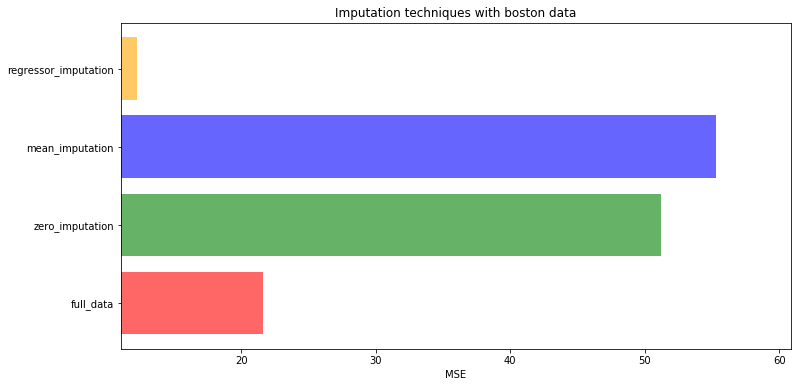

In [60]:
import matplotlib.pyplot as plt
# 将所得的结果画出图
x_labels = ['full_data',
           'zero_imputation',
           'mean_imputation',
           'regressor_imputation']
colors = ['r','g','b','orange']

plt.figure(figsize=(12,6))
# 添加子图
ax = plt.subplot(111)

for i in np.arange(len(mse)):# arange(len(mse))
    ax.barh(i,mse[i], color=colors[i],alpha=0.6,align='center')

ax.set_title('Imputation techniques with boston data')
ax.set_xlim(left=np.min(mse)*0.9,right=np.max(mse)*1.1)
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel('MSE')
# 把y命名好
# ax.invert_yaxis()
ax.set_yticklabels(x_labels)
plt.show()